In [1]:
import numpy as np
import lqrpols
import matplotlib.pyplot as plt

Here is a link to [lqrpols.py](http://www.argmin.net/code/lqrpols.py)


In [2]:
np.random.seed(1337)

# state transition matrices for linear system: 
#     x(t+1) = A x (t) + B u(t)
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])
d,p = B.shape

# LQR quadratic cost per state
Q = np.array([[1,0],[0,0]])

# initial condition for system
z0 = -1 # initial position
v0 = 0  # initial velocity
x0 = np.vstack((z0,v0))

R = np.array([[1.0]])

# number of time steps to simulate
T = 10

# amount of Gaussian noise in dynamics
eq_err = 1e-2

In [3]:
# N_vals = np.floor(np.linspace(1,75,num=7)).astype(int)
N_vals = [1,2,5,7,12,25,50,75,100,125]
N_trials = 10

### Bunch of matrices for storing costs
J_finite_nom = np.zeros((N_trials,len(N_vals)))
J_finite_nomK = np.zeros((N_trials,len(N_vals)))
J_finite_rs = np.zeros((N_trials,len(N_vals)))
J_finite_ur = np.zeros((N_trials,len(N_vals)))
J_finite_pg = np.zeros((N_trials,len(N_vals)))
J_inf_nom = np.zeros((N_trials,len(N_vals)))
J_inf_rs = np.zeros((N_trials,len(N_vals)))
J_inf_ur = np.zeros((N_trials,len(N_vals)))
J_inf_pg = np.zeros((N_trials,len(N_vals)))


# cost for finite time horizon, true model
J_finite_opt = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A,B)

### Solve for optimal infinite time horizon LQR controller
K_opt = -lqrpols.lqr_gain(A,B,Q,R)
# cost for infinite time horizon, true model
J_inf_opt = lqrpols.cost_inf_K(A,B,Q,R,K_opt) 

# cost for zero control
baseline = lqrpols.cost_finite_K(A,B,Q,R,x0,T,np.zeros((p,d)))

# model for nominal control with 1 rollout
A_nom1,B_nom1 = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,1,T)
print(A_nom1)
print(B_nom1)

# cost for finite time horizon, one rollout, nominal control
one_rollout_cost = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom1,B_nom1)
K_nom1 = -lqrpols.lqr_gain(A_nom1,B_nom1,Q,R)
one_rollout_cost_inf = lqrpols.cost_inf_K(A,B,Q,R,K_nom1)

for N in range(len(N_vals)):
    for trial in range(N_trials):
        
        # nominal model, N x 40 to match sample budget of policy gradient
        A_nom,B_nom = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,N_vals[N]*40,T);
        # finite time horizon cost with nominal model
        J_finite_nom[trial,N] = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom,B_nom)
        # Solve for infinite time horizon nominal LQR controller
        K_nom = -lqrpols.lqr_gain(A_nom,B_nom,Q,R)
        # cost of using the infinite time horizon solution for finite time horizon
        J_finite_nomK[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_nom)
        # infinite time horizon cost of nominal model
        J_inf_nom[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_nom)

        # policy gradient, batchsize 8 per iteration
        K_pg = lqrpols.policy_gradient_adagrad_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_pg[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_pg)
        J_inf_pg[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_pg)
        
        # random search, batchsize 4, so uses 8 rollouts per iteration
        K_rs = lqrpols.random_search_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_rs[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_rs)
        J_inf_rs[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_rs)

        # uniformly random sampling, N x 40 to match sample budget of policy gradient
        K_ur = lqrpols.uniform_random_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*40,T)
        J_finite_ur[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_ur)
        J_inf_ur[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_ur)

[[  1.00032885e+00   9.99484822e-01]
 [  2.11465750e-04   9.99153277e-01]]
[[-0.00174996]
 [ 0.99998723]]


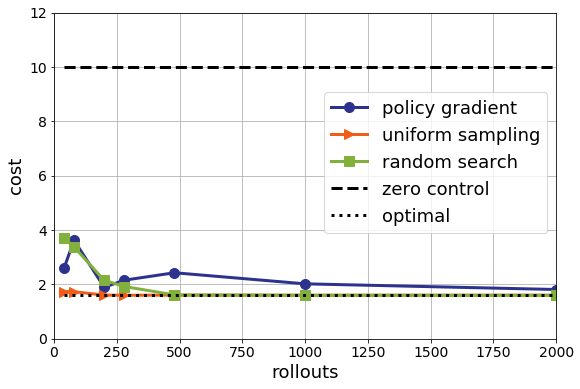

In [4]:
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
          
label_fontsize = 18
tick_fontsize = 14
linewidth = 3
markersize = 10

tot_samples = 40*np.array(N_vals)

plt.plot(tot_samples,np.amin(J_finite_pg,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')

plt.plot(tot_samples,np.amin(J_finite_ur,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')

plt.plot(tot_samples,np.amin(J_finite_rs,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')

plt.plot([tot_samples[0],tot_samples[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.plot([tot_samples[0],tot_samples[-1]],[J_finite_opt, J_finite_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,2000,0,12])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

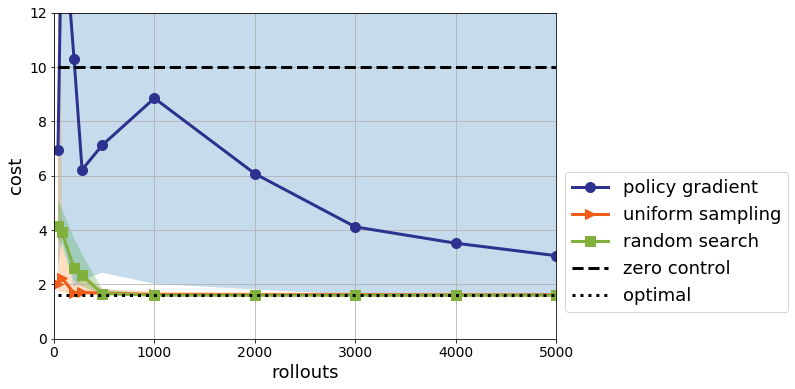

In [5]:
plt.plot(tot_samples,np.median(J_finite_pg,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')
plt.fill_between(tot_samples, np.amin(J_finite_pg,axis=0), np.amax(J_finite_pg,axis=0), alpha=0.25)

plt.plot(tot_samples,np.median(J_finite_ur,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')
plt.fill_between(tot_samples, np.amin(J_finite_ur,axis=0), np.amax(J_finite_ur,axis=0), alpha=0.25)

plt.plot(tot_samples,np.median(J_finite_rs,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')
plt.fill_between(tot_samples, np.amin(J_finite_rs,axis=0), np.amax(J_finite_rs,axis=0), alpha=0.25)


plt.plot([tot_samples[0],tot_samples[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.plot([tot_samples[0],tot_samples[-1]],[J_finite_opt, J_finite_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,5000,0,12])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

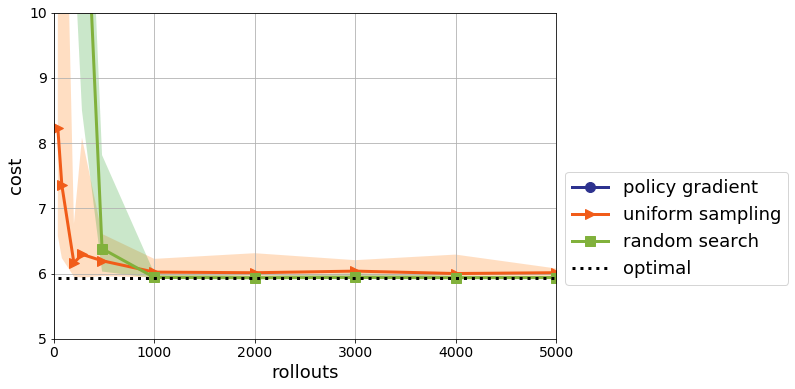

In [6]:
plt.plot(tot_samples,np.median(J_inf_pg,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')
plt.fill_between(tot_samples, np.amin(J_inf_pg,axis=0), np.minimum(np.amax(J_inf_pg,axis=0),15), alpha=0.25)

plt.plot(tot_samples,np.median(J_inf_ur,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')
plt.fill_between(tot_samples, np.amin(J_inf_ur,axis=0), np.minimum(np.amax(J_inf_ur,axis=0),15), alpha=0.25)

plt.plot(tot_samples,np.median(J_inf_rs,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')
plt.fill_between(tot_samples, np.amin(J_inf_rs,axis=0), np.minimum(np.amax(J_inf_rs,axis=0),15), alpha=0.25)

plt.plot([tot_samples[0],tot_samples[-1]],[J_inf_opt, J_inf_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,5000,5,10])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

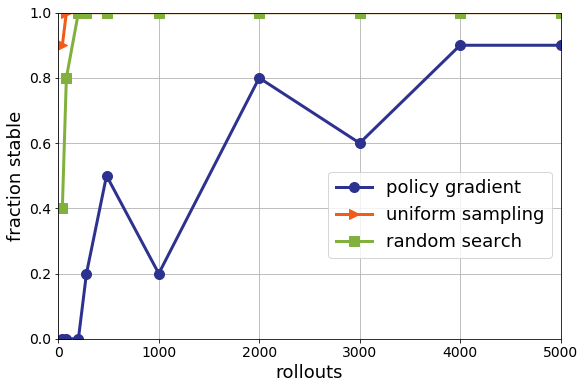

In [7]:
plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_pg),axis=0)/10,'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')

plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_ur),axis=0)/10,'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')

plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_rs),axis=0)/10,'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')

plt.axis([0,5000,0,1])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('fraction stable',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

In [8]:
one_rollout_cost-J_finite_opt

3.5546858458967989e-06

In [9]:
one_rollout_cost_inf-J_inf_opt

6.2260945030701009e-06

In [5]:
np.ones((1,2))


array([[ 1.,  1.]])